In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [22]:
# Load the dataset
df = pd.read_csv("../data/df_pooled_ranking.csv")  # Replace with your dataset path

# Data Preparation
df["ano"] = df["ano"].astype(int)


In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nome                  1646 non-null   object 
 1   ida                   1646 non-null   float64
 2   diff_fase             1646 non-null   float64
 3   ponto_virada_encoded  1646 non-null   int64  
 4   anos_pm               1646 non-null   float64
 5   bolsista_encoded      1646 non-null   int64  
 6   ipv                   1646 non-null   float64
 7   corraca               1646 non-null   object 
 8   ponto_virada          1646 non-null   object 
 9   ian                   1646 non-null   float64
 10  pedra                 1646 non-null   object 
 11  pedra_encoded         1646 non-null   int64  
 12  iaa                   1646 non-null   float64
 13  ips                   1646 non-null   float64
 14  ieg                   1646 non-null   float64
 15  ipp                  

In [24]:
df.drop(
    columns=[
        "corraca",
        "cf",
        "ct",
        "pedra",
        "sexo",
        "fase",
        "ponto_virada",
        "pedra_encoded",
    ],
    inplace=True,
)


In [52]:
# Step 1: Feature Selection using Random Forest
features_for_importance = df.drop(columns=["nome", "cg"])
target_for_importance = df["cg"]

# Standardize the features
scaler = StandardScaler()
features_scaled_for_importance = scaler.fit_transform(features_for_importance)

# Train a Random Forest to get feature importance
rf = RandomForestRegressor(random_state=42)
rf.fit(features_scaled_for_importance, target_for_importance)

# Get feature importances and sort them
importances = rf.feature_importances_
feature_names = features_for_importance.columns
sorted_indices = np.argsort(importances)[::-1]

# Print the most important features
print("Feature ranking:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature ranking:
inde: 0.682480124416955
ano: 0.07656210278105194
ipv: 0.052941160918958216
ida: 0.033843362660836
ipp: 0.029544547067766453
idade: 0.029162076249467213
ieg: 0.02707700846599386
iaa: 0.021202154270442967
ips: 0.013279950475657908
anos_pm: 0.012346393113273691
sexo_encoded: 0.00647979416158693
diff_fase: 0.00543896762480132
bolsista_encoded: 0.0044279138167307415
na_fase: 0.002686575510380056
ian: 0.001606788808865245
ponto_virada_encoded: 0.0009210796572324802


In [48]:
# feature_names[sorted_indices].to_list()[:12]


['inde',
 'ano',
 'ipv',
 'ida',
 'ipp',
 'idade',
 'ieg',
 'iaa',
 'ips',
 'anos_pm',
 'sexo_encoded']

In [49]:
# Select the top 10 most important features
# features_scaled_for_importance = features_scaled_for_importance[:, sorted_indices[:11]]


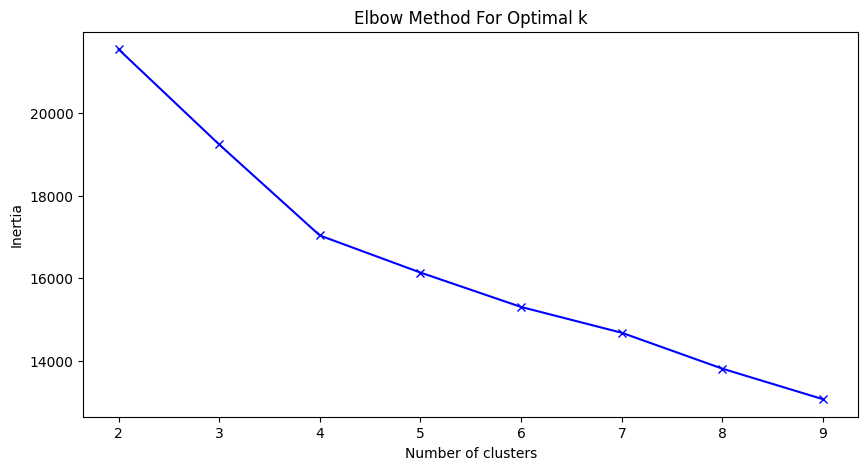

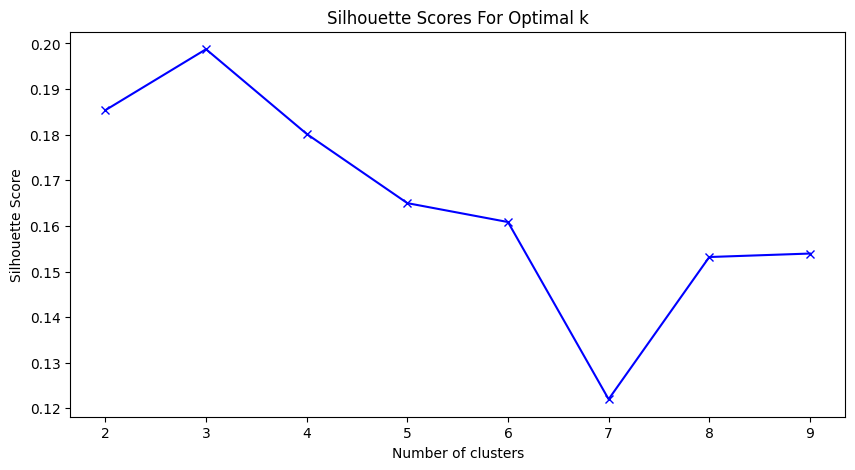

In [53]:
# Step 2: Optimal Number of Clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_for_importance)
    inertia.append(
        kmeans.inertia_
    )  # Sum of squared distances to the nearest cluster center
    silhouette_avg = silhouette_score(features_scaled_for_importance, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores For Optimal k")
plt.show()


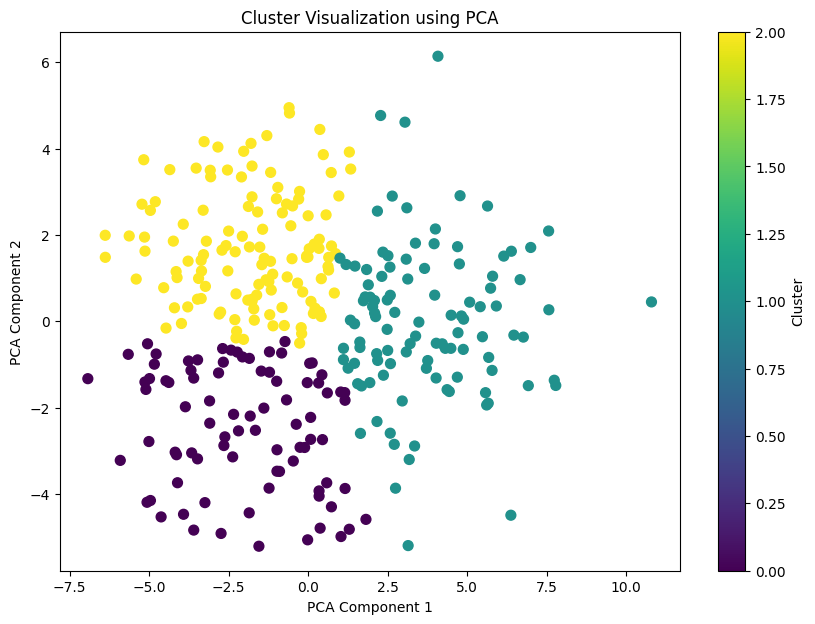

In [68]:
# Step 3: Time-Based Clustering and Predictive Modeling
# Select the most important features based on Random Forest importance

# We will pivot the data to create a time series for each student based on their performance over the three years
# pivot_df = df.pivot(
#     index="nome", columns="ano", values=["iaa", "ieg", "inde", "ipv", "ipp", "cg"]
# )
pivot_df = df.pivot(
    index="nome",
    columns="ano",
    values=[
        "inde",
        "ano",
        "ipv",
        "ida",
        "ipp",
        "idade",
        "ieg",
        "iaa",
        "ips",
        "anos_pm",
        "cg",
    ],
)

pivot_df.columns = ["_".join(map(str, col)).strip() for col in pivot_df.columns.values]
pivot_df = pivot_df.dropna()  # Drop rows with missing data

# Standardize the time-based features
pivot_df_scaled = scaler.fit_transform(pivot_df)

# Apply KMeans clustering for time-based trajectories based on selected optimal number of clusters (use k from the elbow method)
optimal_k = 3  # Based on Elbow/Silhouette methods
kmeans_time_based = KMeans(n_clusters=optimal_k, random_state=42)
pivot_df["cluster"] = kmeans_time_based.fit_predict(pivot_df_scaled)

# Step 4: Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pivot_df_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=pivot_df["cluster"],
    cmap="viridis",
    s=50,
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization using PCA")
plt.colorbar(label="Cluster")
plt.show()


In [69]:
pivot_df.columns


Index(['inde_2020', 'inde_2021', 'inde_2022', 'ano_2020', 'ano_2021',
       'ano_2022', 'ipv_2020', 'ipv_2021', 'ipv_2022', 'ida_2020', 'ida_2021',
       'ida_2022', 'ipp_2020', 'ipp_2021', 'ipp_2022', 'idade_2020',
       'idade_2021', 'idade_2022', 'ieg_2020', 'ieg_2021', 'ieg_2022',
       'iaa_2020', 'iaa_2021', 'iaa_2022', 'ips_2020', 'ips_2021', 'ips_2022',
       'anos_pm_2020', 'anos_pm_2021', 'anos_pm_2022', 'cg_2020', 'cg_2021',
       'cg_2022', 'cluster'],
      dtype='object')

In [73]:
# Predictive Modeling: Use performance metrics from 2020 and 2021 to predict 2022 'cg'
features = pivot_df[pivot_df.columns.difference(["cg_2022", "cg_2021", "cg_2020"])]
#     [
#         "iaa_2020",
#         "iaa_2021",
#         "ieg_2020",
#         "ieg_2021",
#         "inde_2020",
#         "inde_2021",
#         "ipv_2020",
#         "ipv_2021",
#         "ipp_2020",
#         "ipp_2021",
#         "cluster",
#     ]
# ]
target = pivot_df["cg_2022"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

# Initialize the XGBoost model
xgb = XGBRegressor(
    random_state=42,
    tree_method="hist",
    device="cuda",
)

# Implement GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=1,
)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV R-squared score: {best_score}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV R-squared score: 0.9993482303117721


In [74]:
# Fitting 3 folds for each of 243 candidates, totalling 729 fits
# Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
# Best CV R-squared score: 0.9993482303117721

# Step 6: Evaluate the tuned model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE (test): {mse_xgb}")
print(f"XGBoost R-squared (test): {r2_xgb}")


XGBoost MSE (test): 17.932263492462447
XGBoost R-squared (test): 0.9997747299209883


In [75]:
y_pred_xgb


array([540.3098   ,  11.115845 , 546.0779   , 137.07648  , 169.27258  ,
       852.93994  ,  40.626587 , 508.67233  ,  22.655518 , 745.1842   ,
       713.6963   , 598.19037  ,  64.94263  , 826.49854  , 795.1056   ,
       750.9354   , 442.43057  ,  89.23453  ,  62.65393  , 649.67334  ,
        19.195831 , 598.2334   ,  34.237335 , 512.90314  , 604.82886  ,
        88.29993  , 802.53973  , 139.18777  , 205.51251  , 557.7493   ,
       387.1988   , 465.49533  , 471.04526  , 809.43945  ,  45.896698 ,
        46.315704 , 367.58026  , 411.48315  , 276.3662   , 394.0977   ,
       396.09262  ,  89.1886   , 589.09247  ,  73.22702  , 799.98596  ,
       745.9361   , 622.1386   , 691.0795   ,   9.93869  , 444.27957  ,
        57.59796  , 252.47105  ,   4.0166626, 387.88083  , 203.80325  ,
       329.29675  , 440.47656  ,   5.9581604, 658.1227   ,  76.33789  ,
         8.683319 , 857.812    , 639.37683  ], dtype=float32)

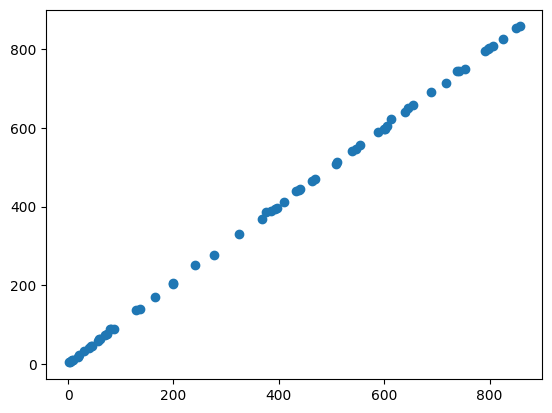

In [19]:
# Compute the correlation matrix to check for multicollinearity
correlation_matrix = data.corr()

correlation_matrix.style.background_gradient(cmap="coolwarm")


,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded,ano_2021,ano_2022
anos_pm,1.000000,0.511746,0.075968,0.009785,-0.095882,-0.009634,-0.064799,0.388553,-0.130786,-0.082663,0.228478,-0.201797,0.003945,-0.041668,0.061084,0.002636,0.079355,-0.063842
bolsista_encoded,0.511746,1.000000,-0.249112,0.234790,-0.009684,0.223288,0.180252,0.254114,0.118261,0.238295,0.294217,-0.101830,0.247107,0.150474,0.256865,-0.003454,0.081869,-0.108149
cg,0.075968,-0.249112,1.000000,-0.354565,-0.323269,-0.351756,-0.598294,0.322529,-0.575793,-0.752786,-0.216040,-0.247108,-0.599130,-0.300789,-0.434532,-0.001174,0.010137,-0.025361
diff_fase,0.009785,0.234790,-0.354565,1.000000,0.058336,0.854130,0.135258,-0.336294,0.155653,0.382036,0.221482,0.083749,0.184852,0.705142,0.133543,-0.007697,0.071254,-0.180757
iaa,-0.095882,-0.009684,-0.323269,0.058336,1.000000,0.062601,0.239410,-0.230479,0.309920,0.461080,0.005567,0.140351,0.267823,0.050215,0.136843,0.009544,-0.014711,-0.055035
ian,-0.009634,0.223288,-0.351756,0.854130,0.062601,1.000000,0.123170,-0.311121,0.135779,0.380627,0.160474,0.038998,0.138295,0.938138,0.107254,-0.005651,0.047169,-0.154339
ida,-0.064799,0.180252,-0.598294,0.135258,0.239410,0.123170,1.000000,-0.246057,0.571757,0.802749,0.125314,0.129288,0.519352,0.100663,0.288878,-0.005796,-0.134558,-0.056090
idade,0.388553,0.254114,0.322529,-0.336294,-0.230479,-0.311121,-0.246057,1.000000,-0.316850,-0.330440,0.261426,-0.124257,-0.156395,-0.294524,-0.028670,-0.019123,-0.007964,0.114700
ieg,-0.130786,0.118261,-0.575793,0.155653,0.309920,0.135779,0.571757,-0.316850,1.000000,0.795627,0.072253,0.099689,0.555251,0.110449,0.286676,-0.039263,-0.203363,0.049032
inde,-0.082663,0.238295,-0.752786,0.382036,0.461080,0.380627,0.802749,-0.330440,0.795627,1.000000,0.352338,0.296969,0.774785,0.329610,0.439161,-0.012108,-0.051939,-0.133621
